# Version 7: Inclusion of Additional Features (Owner_Count)

## Introduction: Changes & Purpose
Version 7 involved the integration of an additional feature, "Owner_Count", into the model.
- **Change:** Added "Owner_Count" to the list of predictors.
- **Purpose:** The hypothesis was that the number of previous owners could influence a vehicle's price, and including this feature might capture additional variability and improve predictions.


🔹 Relevant features after Lasso: ['Brand', 'Model', 'Engine_Size', 'Fuel_Type', 'Transmission', 'Owner_Count', 'Car_Age', 'Mileage_sqrt']
🚀 Version 7 - RMSE: 1333.45, R²: 0.8092


2025/03/16 00:01:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ MLflow run completed!


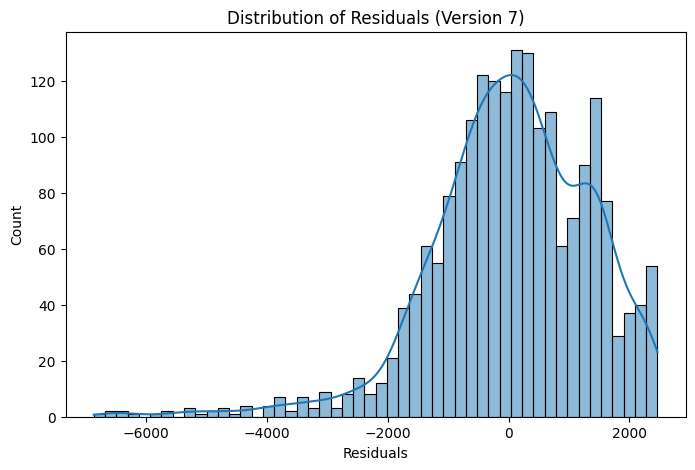

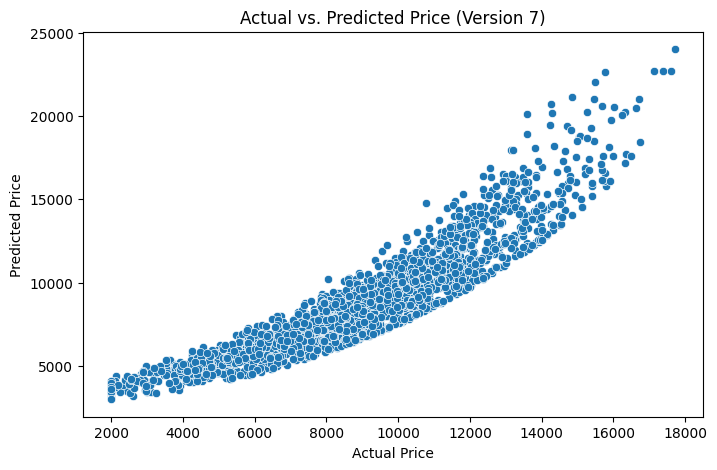

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import mlflow.sklearn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Initialize MLflow experiment
mlflow.set_experiment("Car Price Prediction - Version 7")

with mlflow.start_run():
    # Load data
    df = pd.read_csv("car_price_dataset.csv")

    # Remove unrealistic values
    df = df[(df["Price"] >= 2000) & (df["Price"] <= 18000)]
    df = df[(df["Mileage"] >= 0) & (df["Mileage"] <= 300000)]
    df = df[(df["Engine_Size"] >= 0.8) & (df["Engine_Size"] <= 6.0)]
    df["Car_Age"] = 2025 - df["Year"]

    # Label encoding for categorical data
    categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
    label_encoders = {}

    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Feature engineering: Transform mileage
    df["Mileage_sqrt"] = np.sqrt(df["Mileage"])

    # Reinsert Brand and Owner_Count
    df["Owner_Count"] = df["Owner_Count"]  # Important info for used cars
    df.drop(columns=["Year", "Mileage"], inplace=True)

    # Standardize numerical features
    scaler = StandardScaler()
    numeric_features = ["Engine_Size", "Mileage_sqrt", "Car_Age", "Doors", "Owner_Count"]
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    # Transform target variable
    df["Log_Price"] = np.log1p(df["Price"])

    # Create training and test data
    X = df.drop(columns=["Price", "Log_Price"])
    y = df["Log_Price"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Lasso model for feature reduction with optimized alpha
    lasso = Lasso(alpha=0.001)  # Less aggressive reduction
    lasso.fit(X_train, y_train)
    feature_importance = np.abs(lasso.coef_)

    # Select relevant features
    selected_features = X.columns[feature_importance > 0]
    print(f"🔹 Relevant features after Lasso: {list(selected_features)}")

    X_train = X_train[selected_features]
    X_test = X_test[selected_features]

    # Test ElasticNet model
    elasticnet = ElasticNet(alpha=0.001, l1_ratio=0.5)  # Combination of L1 and L2
    elasticnet.fit(X_train, y_train)

    # Predictions & evaluation
    y_pred_log = elasticnet.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
    r2 = r2_score(np.expm1(y_test), y_pred)

    print(f" Version 7 - RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # Calculate confidence intervals
    X_train_sm = sm.add_constant(X_train)  # Statsmodels requires constant
    model_sm = sm.OLS(y_train, X_train_sm).fit()
    conf_interval = model_sm.conf_int(alpha=0.05)  # 95% confidence interval

    # Log results in MLflow
    mlflow.log_params({"Model": "ElasticNet", "alpha": 0.001, "l1_ratio": 0.5})
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2_Score", r2)

    # Save model
    model_filename = "elasticnet_model_v7.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(elasticnet, f)

    # Ensure the file exists before logging it in MLflow
    import os
    if os.path.exists(model_filename):
        mlflow.log_artifact(model_filename)
    else:
        print(f" File {model_filename} not found – will not be logged in MLflow.")

    # Save confidence intervals as artifact
    conf_interval.to_csv("confidence_intervals_v7.csv")
    mlflow.log_artifact("confidence_intervals_v7.csv")

    mlflow.sklearn.log_model(elasticnet, "elasticnet_model_v7")

    print("✅ MLflow run completed!")

    # Visualization: Residual analysis
    plt.figure(figsize=(8, 5))
    sns.histplot(np.expm1(y_test) - y_pred, bins=50, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Count")
    plt.title(f"Distribution of Residuals (Version 7)")
    plt.show()

    # Visualization: Actual vs. predicted price
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=np.expm1(y_test), y=y_pred)
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"Actual vs. Predicted Price (Version 7)")
    plt.show()


## Results Discussion
With the additional "Owner_Count" feature, Version 7 produced an RMSE of *1333.45* and an R² of *0.8092*.  
Although there was only a slight improvement compared to Version 6, this suggests that "Owner_Count" contributes some extra information, but its overall impact on model performance is relatively modest.
